# Design Matrices and Evaluating Individual Regressors

In the previous notebook, we learned how to fit a linear encoding model with ridge regression. Ultimately, we would like to understand what variables have the strongest influence on neural activity. We can do that by looking at the $\beta$ values for individual regressors, as we did in the last notebook. We can also compute the variance explained ($R^2$) for a particular variable. 

Here, we will learn how to compute the variance explained ($R^2$) by individual task variables, while applying the functions we wrote previously in `2_Fitting_Neural_Data.ipynb`.

#### Load the data, same as before

In [41]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm

import encoding_tools

data_path = encoding_tools.download_neural_data("miniscope") #Download data
design_matrix, Y_raw_fluorescence, neuron_footprints, frames_per_trial, frame_rate, aligned_segment_start = encoding_tools.load_miniscope(data_path)

### Computing alpha values and $R^2$
For this notebook, we will import the functions `find_best_alphas()` and `cross_val_ridge()`. These functions will handle the operations that we coded in the previous notebook:

- `find_best_alphas()` will do a grid-search to find the optimal alpha values
- `cross_val_ridge()` will take those alphas and return a cross-validated $R^2$ for each neuron.

In [42]:
# show function documentation
??encoding_tools.find_best_alphas 

Signature:
encoding_tools.find_best_alphas(
    X,
    Y,
    alpha_test_range,
    cv=None,
    scoring='r2',
)
Source:   
def find_best_alphas(X,Y, alpha_test_range, cv=None, scoring='r2'):
    """Use SKLearn's RidgeCV to return the best alpha values from a specified alpha_test_range

    Parameters
    ----------
    X : ndarray
        input array of predictor variables
    Y : ndarray
        array of variables to be predicted with ridge regression
    alpha_test_range : ndarray
        an array of alpha values to be tested with RidgeCV
    cv : _type_, optional
        _description_, by default None
    scoring : str, optional
        _description_, by default 'r2'

    Returns
    -------
    ndarray
        an array of alpha values.
    """
    ridge_grid_search = RidgeCV(alphas=alpha_test_range,
                                fit_intercept=False,
                                alpha_per_target=True,
                                cv=cv,
                                scori

In [43]:
??encoding_tools.cross_val_ridge

Signature: encoding_tools.cross_val_ridge(X, Y, alphas, n_folds)
Source:   
def cross_val_ridge(X, Y, alphas, n_folds):
    """Compute the cross-validated r_squared for a set of alpha values

    Parameters
    ----------
    X : ndarray
        input array of predictor variables
    Y : ndarray
        array of variables to be predicted with ridge regression
    alphas : ndarray
        list of alphas for each target
    n_folds : int
        number of folds for cross-validation

    Returns
    -------
    [ndarray, ndarray]
        a list containing the r_squared values at the first index and the beta values at the second
    """
    kf = KFold(n_splits=n_folds, shuffle=True) 
    custom_scaler = standardize_x_cols(column_idx = np.arange(832, 1258)) 
    ridge_model = Ridge(alpha=alphas, fit_intercept=False)
    pipe = Pipeline(steps=[('scaler', custom_scaler),
                           ('ridge', ridge_model)])

    betas = []
    r_squared = []
    for train_index, test_index in k

In the following cell, we are going to run these functions on the full design matrix, which includes task variables (such as stimulus strength and the mouse's decision), head orientation, and video tracking with DeepLabCut. We will then plot the variance explained for each neuron recorded in this seession. The output should be very similar to what we saw in the last notebook, because we are fitting our model with the same design matrix $X$ and the same neural data $Y$.

In [44]:
from scipy.stats import zscore
Y = zscore(Y_raw_fluorescence, axis=0)
scaler_obj = encoding_tools.standardize_x_cols(column_idx=np.arange(832, 1258)).fit(design_matrix) #Cols 0:827 are task vars, cols 828:832 are head orientation
X = scaler_obj.transform(design_matrix)

print(f'Shape of x is {X.shape}')
print(f'Shape of y is {Y.shape}')

N_FOLDS = 10
alpha_test_range = 10**np.linspace(-10,9,50)
print('Computing alphas...')
best_alphas = encoding_tools.find_best_alphas(X, Y, alpha_test_range) # this will take a second to run
print('Computing cross-validated scores...')
r_squared_scores, betas = encoding_tools.cross_val_ridge(X, Y, best_alphas, n_folds=N_FOLDS) # this will take a second to run

Shape of x is (47196, 1258)
Shape of y is (47196, 555)
Computing alphas...
Computing cross-validated scores...


### Plot $R^2$ averaged across folds for each neuron

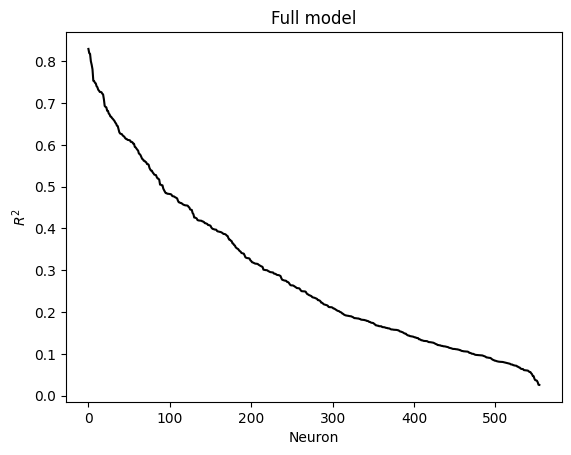

In [45]:
# plot R^2 averaged across folds for each neuron
average_scores = np.mean(r_squared_scores, axis=0)
plt.plot(np.sort(average_scores)[::-1], color='black')
plt.xlabel('Neuron')
plt.ylabel('$R^2$')
plt.title('Full model')
plt.show()

You should notice that the variance explained is similar to what we saw before. This plot gives us a nice overview of how much variance we can explain with our full model (meaning that we have included as many predictors as we can think of). Unfortunately this data is not very interpretable: we don't actually know **what** variables the neurons are most strongly encoding.

To understand what individual neurons are most strongly encoding, we will need to train **single variable models**, which contain shuffled versions of the design matrix $X$, where we randomly shuffle regressors that are not of interest.

## Exercise: Compute the variance explained solely by choice
To compute the variance explained by choice, we need to manipulate our design matrix. We will do that by randomly shuffling all of the columns within our design matrix, except for the columns that contain the choice regressor. 

In [46]:
def shuffle_design_matrix(design_matrix, shuffle_inds):
    for ind in shuffle_inds:
        permutation_indices = np.random.choice(design_matrix.shape[0], size=design_matrix.shape[0], replace=False) #need to generate a new set of indices for each regressor
        design_matrix[:,ind] = design_matrix[permutation_indices,ind] 
    return design_matrix

n_regressors = design_matrix.shape[1]
shuffle_inds = np.hstack((np.arange(0, frames_per_trial+1), np.arange(2*frames_per_trial+1, n_regressors)))

design_matrix_choice_only = shuffle_design_matrix(np.array(design_matrix), shuffle_inds) # shuffle everything but choice

#### Run the regression with the shuffled design matrix

In [47]:
scaler_obj = encoding_tools.standardize_x_cols(column_idx=np.arange(832, 1258)).fit(design_matrix_choice_only)
X = scaler_obj.transform(design_matrix_choice_only)

print('Computing alphas...')
best_alphas = encoding_tools.find_best_alphas(X, Y, alpha_test_range) # this will take a second to run
print('Computing cross-validated scores...')
r_squared_scores_choice, _ = encoding_tools.cross_val_ridge(X, Y, best_alphas, n_folds=N_FOLDS) # this will take a second to run

average_scores_choice = np.mean(r_squared_scores_choice, axis=0)

Computing alphas...
Computing cross-validated scores...


### Plot the variance explained by choice
Here, we are going to sort the neurons on our plot by the amount of variance we can explain with the full model. We will plot the "full model" variance explained, and the variance explained by the "choice" task variable.

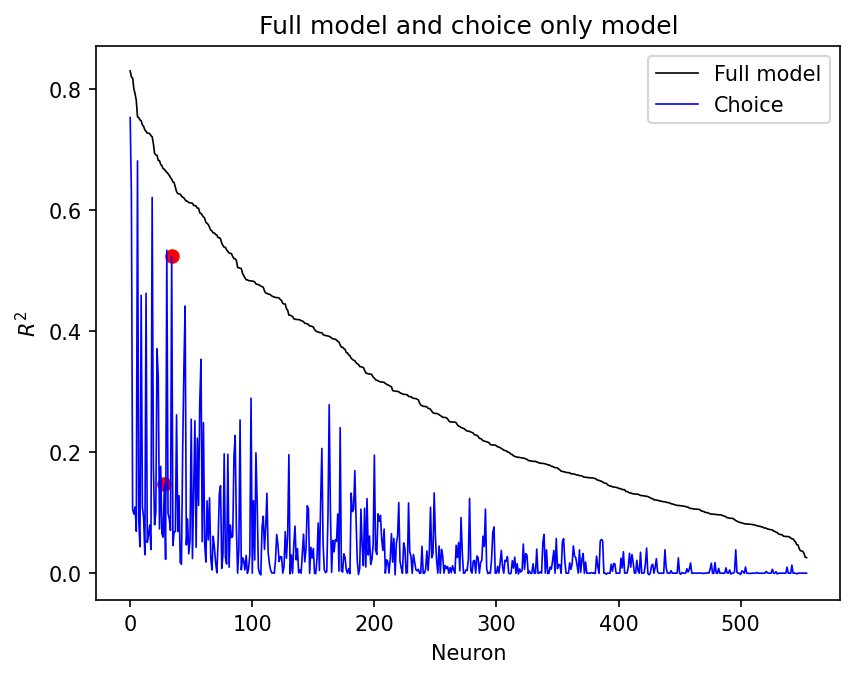

In [48]:
# plot R^2 averaged across folds for each neuron
sorting_indices = np.argsort(average_scores)[::-1]
example_neuron_idx = [np.where(sorting_indices==56)[0][0], np.where(sorting_indices==12)[0][0]]

fig, ax = plt.subplots(dpi=150)
plt.plot(average_scores[sorting_indices], color='black', label='Full model', linewidth=.8)
plt.plot(average_scores_choice[sorting_indices], color='blue', label='Choice', linewidth=.8)
ax.scatter(example_neuron_idx, average_scores_choice[[56,12]], color = 'red')
plt.xlabel('Neuron')
plt.ylabel('$R^2$')
plt.title('Full model and choice only model')
plt.legend()
plt.show()

### Now we have a clearer picture of how strongly choice is encoded across our population of neurons
Take note of our example neurons labeled in red. It seems one of them more strongly encodes choice than the other. Does this match what we saw in `2_Fitting_Neural_Data.ipynb`?

## Introducing unique variance explained, $\Delta R^2$
We just learned how to compute the variance explained ($R^2$) for an individual variable. We can also compute the *unique variance explained* ($\Delta R^2$) by a particular variable. 

Figure 4 from [Musall *et al* 2019](https://www.nature.com/articles/s41593-019-0502-4) provides a nice illustration of unique variance explained.

<div>
<img src="images/delta_r_squared.PNG" width="800"/>
</div>

As we discussed in `1_Ridge_Regression.ipynb`, the whole reason we are using ridge regression to solve these systems of equations is because regressors are often correlated with each other. Since ridge regression will spread variance across correlated regressors, each individual regressor will explain some amount of *redundant* variance (variance explainable by other regressors) and some amount of *unique* variance (variance only explainable by that particular regressor). 

- $R^2$ (what we just computed for choice) includes the redundant variance and the unique variance.
- $\Delta R^2$ includes just the unique variance. It is a more conservative metric.


To compute $\Delta R^2$, we will first compute the variance of the full model (which we did previously). We will then compute the variance explained on a model where the variable of interest has been shuffled. The $\Delta R^2$ is the difference in variance explained between these two models.

To compute the $\Delta R^2$ for choice:

$$
\Delta R^2_{\text{choice}} = R^2_{\text{full model}} - R^2_{\text{choice shuffle}}
$$


We've already computed $R^2_{\text{full model}}$, so let's compute $R^2_{\text{choice shuffle}}$ and then get the $\Delta R^2$.

## Exercise: compute the unique variance explained for choice

In [49]:
n_regressors = design_matrix.shape[1]
shuffle_inds = np.arange(frames_per_trial+1, 2*frames_per_trial+1)
design_matrix_choice_shuffled = shuffle_design_matrix(np.array(design_matrix), shuffle_inds)  # shuffle ONLY choice

### Run the regression

In [50]:
scaler_obj = encoding_tools.standardize_x_cols(column_idx=np.arange(832, 1258)).fit(design_matrix_choice_shuffled)
X = scaler_obj.transform(design_matrix_choice_shuffled)

print('Computing alphas...')
best_alphas = encoding_tools.find_best_alphas(X, Y, alpha_test_range) # this will take a second to run
print('Computing cross-validated scores...')
r_squared_scores_choice_shuffled, _ = encoding_tools.cross_val_ridge(X, Y, best_alphas, n_folds=N_FOLDS) # this will take a second to run

average_scores_choice_shuffled = np.mean(r_squared_scores_choice_shuffled, axis=0)

choice_delta_r2 = average_scores - average_scores_choice_shuffled #compute deltaR2 from the two models we trained

Computing alphas...
Computing cross-validated scores...


### Plot the **unique** variance explained by choice


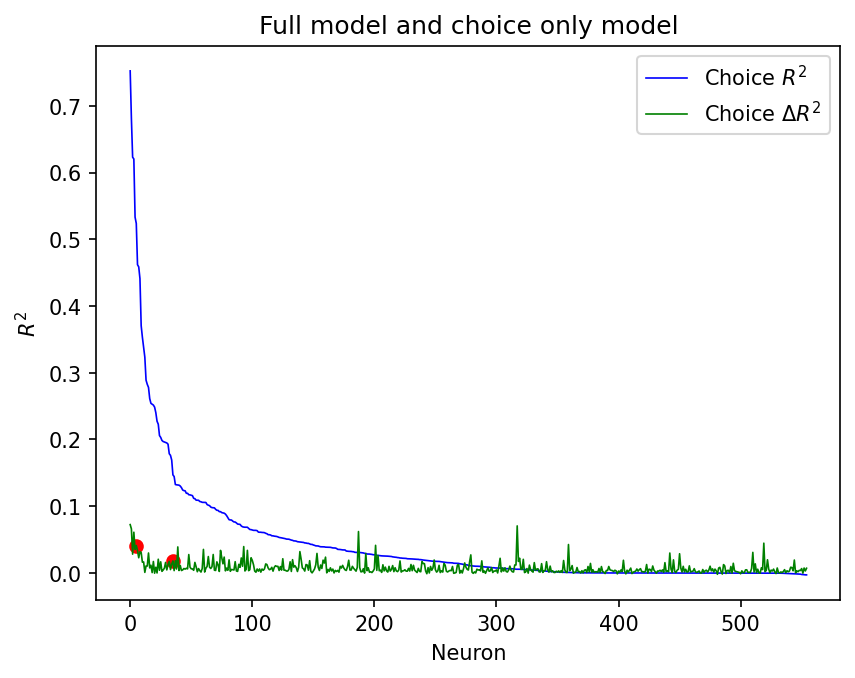

In [59]:
# plot R^2 averaged across folds for each neuron
sorting_indices = np.argsort(average_scores_choice)[::-1]
example_neuron_idx = [np.where(sorting_indices==56)[0][0], np.where(sorting_indices==12)[0][0]]

fig, ax = plt.subplots(dpi=150)
plt.plot(average_scores_choice[sorting_indices], color='blue', label='Choice $R^2$', linewidth=.8)
plt.plot(choice_delta_r2[sorting_indices], color='green', label='Choice $\Delta R^2$', linewidth=.8)
ax.scatter(example_neuron_idx, choice_delta_r2[[56,12]], color = 'red')
plt.xlabel('Neuron')
plt.ylabel('$R^2$')
plt.title('Full model and choice only model')
plt.legend()
plt.show()

As you can see in the plot above, $\Delta R^2$ values tend to be much lower than $R^2$!

### Congrats on finishing the final notebook! You now know how to compute and extract the three basic metrics from a linear encoding model
- $\beta$ weights
- $R^2$
- $\Delta R^2$ 